Shape = (10976, 794)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.414023038136268
1  7.282392470126343
2  7.148931657128527
3  7.023173621941767
4  6.928397756716833
5  6.833986911759702
6  6.767777494971153
7  6.692855420061662
8  6.621732791563399
9  6.559637318389343
10  6.495264703859037
11  6.454525984760899
12  6.4181203523255785
13  6.381611957662029
14  6.352696647659881
15  6.328739859172986
16  6.305393020664806
17  6.287943601808134
18  6.276256867293498
19  6.266052517823878
20  6.2547987956066375
21  6.240130176519315
22  6.233026055292696
23  6.2228550108904885
24  6.204738896662777
25  6.1976820199560185
26  6.192340932339141
27  6.1895453293945
28  6.185923732453966
29  6.183915676406151
30  6.179813544364196
31  6.175955122335939
32  6.174772278133318
33  6.173375288464131
34  6.171249714009472
35  6.169042003697044
36  6.166303977237568
37  6.16469708113706
38  6.163446861974718
39  6.160494633640342
40  6.158992845740619
41  6.1555464344484205
42  6.

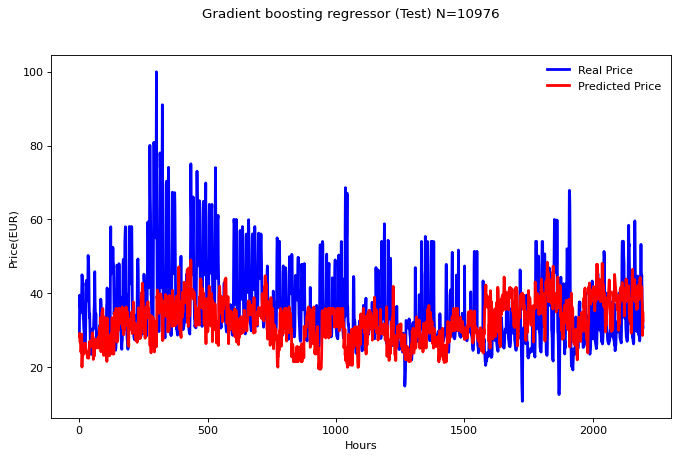

In [3]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
Top = 30

path = "/content/drive/MyDrive/Colab Notebooks/Project/05_Weather_FI_Extend.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]

#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape
print("Shape = "+str(Pred_index))

Y_temp = Y.copy()
Y_temp.index = Y_temp.index + DateOffset(hours=-hour_ahead)
Y_temp.rename('Y', inplace=True)
XY = X.copy()
XY = XY.join(Y_temp)
XYC = XY.corr()
YCorr = XYC.drop(First.columns.difference(['Y']), axis=1)
YCorr.sort_values(by=['Y'], inplace=True, ascending=False)


TopIndex = YCorr.index[(803-Top):803] 
X.drop(X.columns.difference(TopIndex), axis=1, inplace=True)


X = X.to_numpy()
Y = Y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()

Shape = (10976, 794)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.392363582418526
1  7.218941530783152
2  7.06202000257541
3  6.9243233125790296
4  6.8063200950619285
5  6.7107300804702925
6  6.624850419998354
7  6.553762884956234
8  6.478591016421738
9  6.419854990459296
10  6.371894072305571
11  6.326384007599482
12  6.289195768094948
13  6.25385241275437
14  6.22414784366285
15  6.202005094757347
16  6.182097924832124
17  6.1576374967231216
18  6.138188778287877
19  6.116939909141135
20  6.09909152083559
21  6.088432771311771
22  6.078944175582911
23  6.069668341248561
24  6.058931678168819
25  6.049963668168909
26  6.04413201713047
27  6.040838179142936
28  6.03680033940234
29  6.032052136373773
30  6.026535350878198
31  6.019554504275332
32  6.014980866322142
33  6.010977241633279
34  6.006812144081758
35  6.003835399527287
36  5.9994216932076805
37  5.993780384893605
38  5.990229652210459
39  5.987313827610202
40  5.984808210138691
41  5.983347677138006
42  5.982

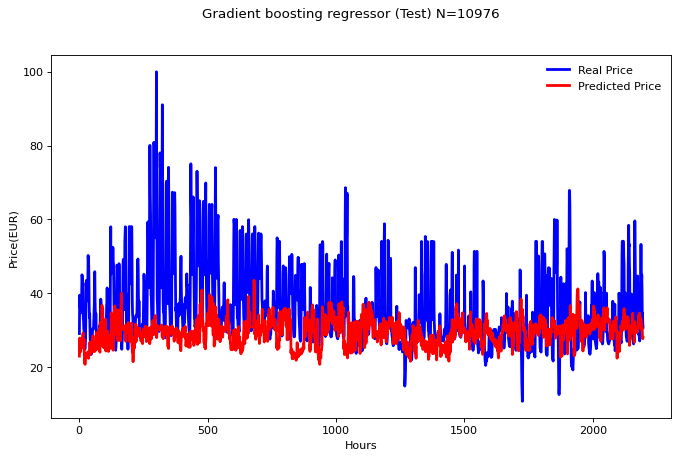

In [4]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
Top = 30

path = "/content/drive/MyDrive/Colab Notebooks/Project/05_Weather_FI_Extend.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]

#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape
print("Shape = "+str(Pred_index))



Y_temp = Y.copy()
Y_temp.index = Y_temp.index + DateOffset(hours=-hour_ahead)
Y_temp.rename('Y', inplace=True)
XY = X.copy()
XY = XY.join(Y_temp)
XYC2 = XY.corr(method='spearman')
YCorr2 = XYC2.drop(First.columns.difference(['Y']), axis=1)
YCorr2.sort_values(by=['Y'], inplace=True, ascending=False)




TopIndex = YCorr2.index[(803-Top):803] 
X.drop(X.columns.difference(TopIndex), axis=1, inplace=True)




X = X.to_numpy()
Y = Y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()

Shape = (10976, 794)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
0  7.475069874521697
1  7.3731485659604665
2  7.286177470514201
3  7.204743288403122
4  7.137803332585097
5  7.0837834406722315
6  7.0257639298439685
7  6.980531795358167
8  6.945801774607594
9  6.915689404815947
10  6.891263377416738
11  6.8675554711838975
12  6.838642678098632
13  6.816289884500348
14  6.777974250841035
15  6.748569512116398
16  6.72368032324327
17  6.698901886675024
18  6.672440172227288
19  6.658274804032497
20  6.644377795924056
21  6.629169729132518
22  6.615202698855634
23  6.60875495661942
24  6.600078559539614
25  6.589244921597175
26  6.584451550207048
27  6.578656699778737
28  6.5748711498051495
29  6.570973691990568
30  6.567743761451911
31  6.564003317975607
32  6.5565287430600945
33  6.553563894978916
34  6.550014700720331
35  6.5469160651461475
36  6.543931148037551
37  6.5418687808574925
38  6.540919528753124
39  6.539971118437746
40  6.539058717015043
41  6.537824365238983
42

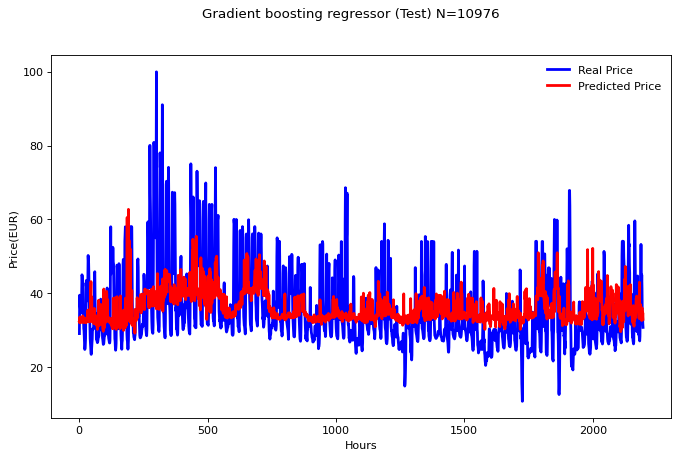

In [5]:
import pandas as pd
import numpy as np
from IPython.display import display
from fastai.imports import *
from sklearn import metrics
from pandas.tseries.offsets import DateOffset
import matplotlib.pyplot as plt

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

hour_ahead = 24
n_estimators = 80
learning_rate = 0.1
Depth = 6
Min_leaf = 20
Top = 30

path = "/content/drive/MyDrive/Colab Notebooks/Project/05_Weather_FI_Extend.csv"
Merge_all = pd.read_csv(path)
dti = pd.to_datetime(Merge_all['DateTime'], format='%Y-%m-%d %H', exact=False)
Merge_all.set_index(pd.Index(dti), inplace=True)
Merge_all.drop(['DateTime'], axis=1, inplace=True)

First = Merge_all.iloc[0:11000, :]
N_index = First.shape
Y_temp = First['FI']
Y = Y_temp.iloc[hour_ahead:N_index[0]]
#Y.reset_index(drop=True, inplace=True)
#Y.columns = [''] * len(Y.columns)


X_temp1 = First.drop(First.columns.difference(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell']), axis=1)
X_temp2 = First.drop(['FI', 'C_SE1 > FI', 'C_FI > SE1', 'C_SE3 > FI', 'C_FI > SE3', 'C_EE > FI', 'C_FI > EE', 'F_FI > SE1', 'F_SE1 > FI', 'F_FI > SE3', 'F_SE3 > FI', 'F_FI > EE', 'F_EE > FI', 'FI Buy', 'FI Sell'], axis=1)
X_temp2_index = X_temp2.index + DateOffset(hours=-hour_ahead)
X_temp2.set_index(X_temp2_index, inplace=True)
#X_temp1 = X_temp1.to_frame()
X_temp = X_temp1.join(X_temp2)
X = X_temp.iloc[0:N_index[0] - hour_ahead]

#X.reset_index(drop=True, inplace=True)
#X.columns = [''] * len(X.columns)
Pred_index = X.shape
print("Shape = "+str(Pred_index))

from sklearn.linear_model import LinearRegression
model2 = LinearRegression()
model2.fit(X, Y)
importance2 = model2.coef_
FeatureR = []
FeatureR_index = X.columns
for i,v in enumerate(importance2):
    FeatureR.append(v)

Yfri = pd.DataFrame({'Index':FeatureR_index})
Yfr = pd.DataFrame({'Y':FeatureR})
Yfr.index = Yfri['Index']
Yfr.sort_values(by=['Y'], inplace=True, ascending=False)




TopIndex = Yfr.index[(803-Top):803] 
X.drop(X.columns.difference(TopIndex), axis=1, inplace=True)




X = X.to_numpy()
Y = Y.to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle=False)



class DecisionTree():
    def __init__(self, x, y, n_features, f_idxs, idxs=None, depth=3, min_leaf=5):
        if idxs is None: idxs=np.arange(len(y))
        self.x, self.y, self.idxs, self.min_leaf, self.f_idxs = x, y, idxs, min_leaf, f_idxs
        self.depth = depth
        #print(f_idxs)
        #         print(self.depth)
        self.n_features = n_features
        self.n, self.c = len(idxs), x.shape[1]
        self.val = np.mean(y[idxs])
        self.score = float('inf')
        self.find_varsplit()

    def find_varsplit(self):
        for i in self.f_idxs: self.find_better_split(i)
        if self.is_leaf: return
        x = self.split_col
        lhs = np.nonzero(x <= self.split)[0]
        rhs = np.nonzero(x > self.split)[0]
        lf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        rf_idxs = np.random.permutation(self.x.shape[1])[:self.n_features]
        self.lhs = DecisionTree(self.x, self.y, self.n_features, lf_idxs, self.idxs[lhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)
        self.rhs = DecisionTree(self.x, self.y, self.n_features, rf_idxs, self.idxs[rhs], depth=self.depth - 1,
                                min_leaf=self.min_leaf)

    def find_better_split(self, var_idx):
        x, y = self.x[self.idxs, var_idx], self.y[self.idxs]
        sort_idx = np.argsort(x)
        sort_y, sort_x = y[sort_idx], x[sort_idx]
        rhs_sum2: object
        rhs_cnt, rhs_sum, rhs_sum2 = self.n, sort_y.sum(), (sort_y ** 2).sum()
        lhs_cnt, lhs_sum, lhs_sum2 = 0, 0., 0.

        for i in range(0, self.n - self.min_leaf - 1):
            xi, yi = sort_x[i], sort_y[i]
            lhs_cnt += 1
            rhs_cnt -= 1
            lhs_sum += yi
            rhs_sum -= yi
            lhs_sum2 += yi ** 2
            rhs_sum2 -= yi ** 2
            if i < self.min_leaf or xi == sort_x[i + 1]:
                continue

            lhs_std = std_agg(lhs_cnt, lhs_sum, lhs_sum2)
            rhs_std = std_agg(rhs_cnt, rhs_sum, rhs_sum2)
            curr_score = lhs_std * lhs_cnt + rhs_std * rhs_cnt
            if curr_score < self.score:
                self.var_idx, self.score, self.split = var_idx, curr_score, xi

    @property
    def split_name(self):
        return self.x.columns[self.var_idx]

    @property
    def split_col(self):
        return self.x[self.idxs, self.var_idx]

    @property
    def is_leaf(self):
        return self.score == float('inf') or self.depth <= 0

    def predict(self, x):
        return np.array([self.predict_row(xi) for xi in x])

    def predict_row(self, xi):
        if self.is_leaf: return self.val
        t = self.lhs if xi[self.var_idx] <= self.split else self.rhs
        return t.predict_row(xi)

def std_agg(cnt, s1, s2):
    try:
        return math.sqrt((s2 / cnt) - (s1 / cnt) ** 2)
    except:
        return 0

xi = X_train
train_index = X_train.shape
yi = y_train - np.mean(y_train)
ei = 0  # initialization of error
predf = np.mean(y_train)  # initial prediction 0


def create_tree(x, y, n_features, sample_sz, depth=3, min_leaf=5):
    idxs = np.random.permutation(len(y))[:sample_sz]
    f_idxs = np.random.permutation(x.shape[1])[:n_features]
    return DecisionTree(x[idxs], y[idxs], n_features, f_idxs,
                        idxs=np.array(range(sample_sz)), depth=depth, min_leaf=min_leaf)


print("hour_ahead = " + str(hour_ahead))
print("n_estimators = " + str(n_estimators))
print("learning_rate = " + str(learning_rate))
print("Depth = " + str(Depth))
print("Min_leaf = " + str(Min_leaf))


trees = []
for i in range(n_estimators):
    tree = create_tree(xi, yi, train_index[1], train_index[0], depth=Depth, min_leaf=Min_leaf)
    predi = tree.predict(xi)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(mean_absolute_error(y_train, predf)))
    ei = y_train - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop
    trees.append(tree)


MSE = mean_squared_error(y_train, predf, squared=True)
print("Training MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Training RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_train, predf)
print("Training MAE  " + str(MAE))



xi = X_test
train_index = X_test.shape
yi = y_test - np.mean(y_test)
ei = 0  # initialization of error
predf = np.mean(y_test)

i = 0
for t in trees:
    predi = t.predict(X_test)
    predf = predf + learning_rate * predi
    print(str(i)+str("  ")+str(np.sqrt(mean_squared_error(y_test, predf, squared=True))))
    print(str(i)+str("  ")+str(mean_absolute_error(y_test, predf)))
    ei = y_test - predf  # needed originl y here as residual always from original y
    yi = ei  # update yi as residual to reloop

    #if i == 1:
    #   break
    i += 1


MSE = mean_squared_error(y_test, predf, squared=True)
print("Testing MSE  " + str(MSE))
RMSE = np.sqrt(MSE)
print("Testing RMSE  " + str(RMSE))
MAE = mean_absolute_error(y_test, predf)
print("Testing MAE  " + str(MAE))


plt.figure(figsize=(10, 6), dpi=80)
plt.suptitle('Gradient boosting regressor (Test) N=' + str(Pred_index[0]))
plt.plot(np.arange(len(y_test))+1, y_test, color="blue", linewidth=2.5, linestyle="-", label='Real Price')
plt.plot(np.arange(len(predf))+1, predf, color="red",  linewidth=2.5, linestyle="-", label='Predicted Price')
plt.xlabel('Hours')
plt.ylabel('Price(EUR)')
plt.legend(frameon=False)
plt.show()